In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
import random
import os
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def visualize_random(folder):
    plt.figure(figsize=(20,10))
    images = os.listdir(folder)
    for i in range(10):
        img = random.choice([x for x in images])
        fig = plt.subplot(5, 5, i + 1)
        fig.axis('off')
        img = mpimg.imread(os.path.join(folder, img))
        fig.imshow(img)

In [3]:
try:
    os.mkdir('total')
    for dir in ['training', 'validation']:
        path = os.path.join('total', dir)
        os.mkdir(path)
        for dir in ['cat', 'dog']:
            n_path = os.path.join(path, dir)
            os.mkdir(n_path)
except Exception:
    print('Existed!')

In [4]:
cats = [x for x in os.listdir('train') if 'cat' in x]
dogs = [x for x in os.listdir('train') if 'dog' in x]
cat_test = random.sample(cats, int(0.2 * len(cats)))
dog_test = random.sample(dogs, int(0.2 * len(dogs)))

In [5]:
for img in os.listdir('train'):
    src_img = os.path.join('train', img)
    if 'cat' in img:
        if img in cat_test:
            dst_img = os.path.join('total/validation/cat', img)
        else:
            dst_img = os.path.join('total/training/cat', img)
    elif 'dog' in img:
        if img in dog_test:
            dst_img = os.path.join('total/validation/dog', img)
        else:
            dst_img = os.path.join('total/training/dog', img)
    copyfile(src_img, dst_img)

In [6]:
gen_train = ImageDataGenerator(rescale=1/255,
                               rotation_range=40, 
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True, 
                               fill_mode='nearest')
gen_valid = ImageDataGenerator(rescale=1/255)

img_train = gen_train.flow_from_directory('total/training', target_size=(150, 150), batch_size=32, class_mode='binary')
img_valid = gen_valid.flow_from_directory('total/validation', target_size=(150, 150), batch_size=32, class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [7]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = Sequential([Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
                        MaxPooling2D(2, 2),
                        Conv2D(64, (3,3), activation='relu'),
                        MaxPooling2D(2,2),
                        Conv2D(128, (3,3), activation='relu'),
                        MaxPooling2D(2,2),
                        Flatten(),
                        Dense(128, activation='relu'),
                        Dense(1, activation='sigmoid')])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
____________________

In [8]:
history = model.fit(img_train, 
                    epochs=20,
                    validation_data=img_valid)

Epoch 1/20
625/625 [==============================] - 214s 338ms/step - loss: 0.7126 - accuracy: 0.5561 - val_loss: 0.6113 - val_accuracy: 0.6760
Epoch 2/20
625/625 [==============================] - 203s 325ms/step - loss: 0.6284 - accuracy: 0.6461 - val_loss: 0.5694 - val_accuracy: 0.7362
Epoch 3/20
625/625 [==============================] - 211s 338ms/step - loss: 0.5731 - accuracy: 0.7076 - val_loss: 0.5154 - val_accuracy: 0.7534
Epoch 4/20
625/625 [==============================] - 210s 336ms/step - loss: 0.5366 - accuracy: 0.7298 - val_loss: 0.4455 - val_accuracy: 0.7986
Epoch 5/20
625/625 [==============================] - 223s 357ms/step - loss: 0.5155 - accuracy: 0.7444 - val_loss: 0.4943 - val_accuracy: 0.7736
Epoch 6/20
625/625 [==============================] - 212s 340ms/step - loss: 0.5015 - accuracy: 0.7553 - val_loss: 0.4197 - val_accuracy: 0.8080
Epoch 7/20
625/625 [==============================] - 257s 411ms/step - loss: 0.4796 - accuracy: 0.7638 - val_loss: 0.4032 -

In [40]:
df_hist = pd.DataFrame(history.history)
df_hist.to_csv('Origin.csv')

In [12]:
model.save('Origin')

INFO:tensorflow:Assets written to: Origin\assets


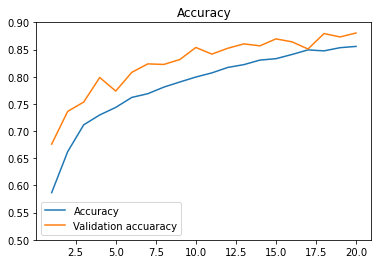

In [37]:
x = np.arange(1, 21)
plt.ylim(0.5,0.9)
plt.title('Accuracy')
plt.plot(x, df_hist.accuracy, label='Accuracy')
plt.plot(x, df_hist.val_accuracy, label='Validation accuaracy')
plt.legend()
plt.show()

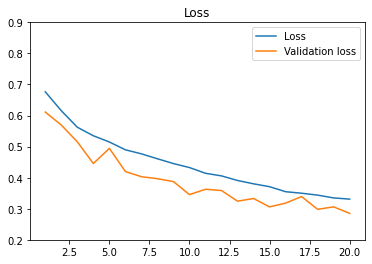

In [38]:
plt.ylim(0.2,0.9)
plt.title('Loss')
plt.plot(x, df_hist.loss, label='Loss')
plt.plot(x, df_hist.val_loss, label='Validation loss')
plt.legend()
plt.show()

In [49]:
def convert_one_img(img_folder, img):
    img_width, img_height = 150, 150
    img = os.path.join(img_folder, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255
    return img

In [52]:
cat_images = os.listdir('total/validation/cat')
cat_result = []
for i, img in enumerate(cat_images):
    pic = convert_one_img('total/validation/cat', os.listdir('total/validation/cat')[i])
    label = 'Cat' if (model.predict(pic) < 0.5).astype('int') else 'Dog'
    cat_result.append(label)

In [64]:
cat_images = os.listdir('total/validation/cat')
cat_value = []
for i, img in enumerate(cat_images):
    pic = convert_one_img('total/validation/cat', os.listdir('total/validation/cat')[i])
    cat_value.append(model.predict(pic))

In [56]:
dog_images = os.listdir('total/validation/dog')
dog_result = []
for i, img in enumerate(dog_images):
    pic = convert_one_img('total/validation/dog', os.listdir('total/validation/dog')[i])
    label = 'Cat' if (model.predict(pic) < 0.5).astype('int') else 'Dog'
    dog_result.append(label)

In [65]:
dog_images = os.listdir('total/validation/dog')
dog_value = []
for i, img in enumerate(dog_images):
    pic = convert_one_img('total/validation/dog', os.listdir('total/validation/dog')[i])
    dog_value.append(model.predict(pic))

In [55]:
print(cat_result.count('Cat'), cat_result.count('Dog'))

2060 440


In [58]:
print(dog_result.count('Cat'), dog_result.count('Dog'))

158 2342


<AxesSubplot:>

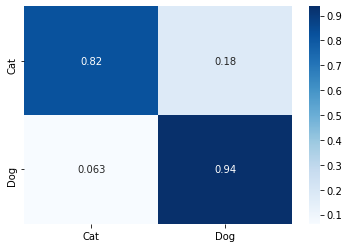

In [86]:
con_matrix = np.asarray([[2060, 440], [158, 2342]])/2500
sns.heatmap(con_matrix, annot=True, xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'], cmap='Blues')

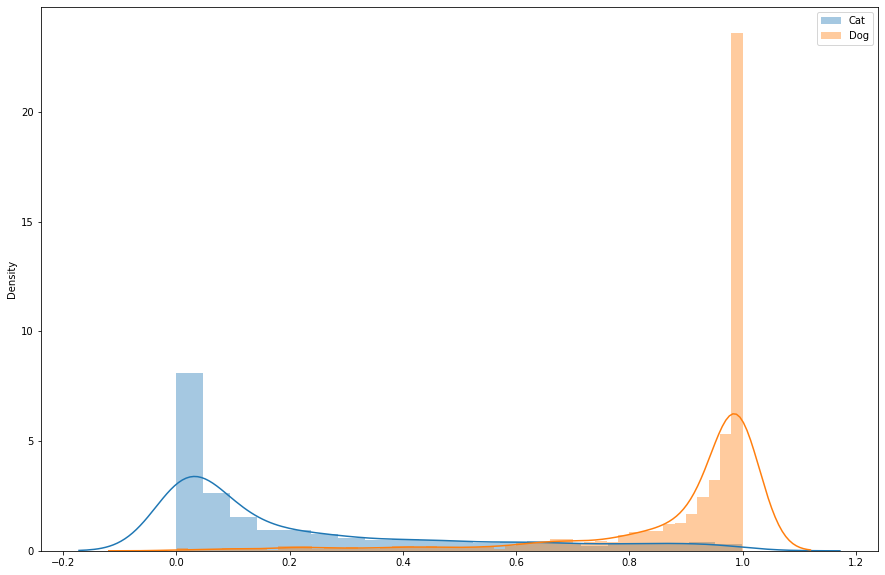

In [75]:
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

plt.figure(figsize=(15,10))
sns.distplot(cat_value, label='Cat')
sns.distplot(dog_value, label='Dog')
plt.legend()

In [92]:
cat_images = os.listdir('total/validation/cat')
cat_result_1 = []
for i, img in enumerate(cat_images):
    pic = convert_one_img('total/validation/cat', os.listdir('total/validation/cat')[i])
    label = 'Cat' if (model.predict(pic) < 0.67).astype('int') else 'Dog'
    cat_result_1.append(label)

In [93]:
dog_images = os.listdir('total/validation/dog')
dog_result_1 = []
for i, img in enumerate(dog_images):
    pic = convert_one_img('total/validation/dog', os.listdir('total/validation/dog')[i])
    label = 'Cat' if (model.predict(pic) < 0.67).astype('int') else 'Dog'
    dog_result_1.append(label)

In [94]:
print(cat_result_1.count('Cat'), cat_result_1.count('Dog'))
print(dog_result_1.count('Cat'), dog_result_1.count('Dog'))

2234 266
271 2229


<AxesSubplot:>

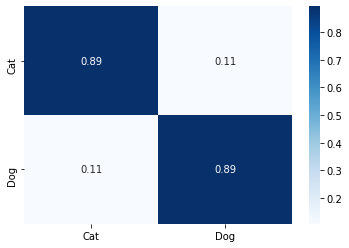

In [95]:
con_matrix = np.asarray([[2234, 266], [271, 2229]])/2500
sns.heatmap(con_matrix, annot=True, xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'], cmap='Blues')